<a href="https://colab.research.google.com/github/satani99/practical_deep_learning_for_coders/blob/main/fast_ai_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *

In [13]:
top_edge = tensor([[1, 1, 1],
                   [0, 0, 0],
                   [-1, -1, -1]]).float()

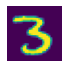

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [5]:
im3_t = tensor(im3)
im3_t[0:3, 0:3] * top_edge 

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [6]:
(im3_t[0:3, 0:3] * top_edge).sum()

tensor(0.)

In [7]:
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [8]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

In [9]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

In [10]:
def apply_kernel(row, col, kernel):
  return (im3_t[row-1:row+2, col-1:col+2] * kernel).sum()

apply_kernel(5, 7, top_edge)

tensor(762.)

In [11]:
[[(i,j) for j in range(1, 5)] for i in range(1, 5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

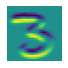

In [14]:
rng = range(1, 27)
top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])

show_image(top_edge3);

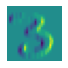

In [17]:
left_edge = tensor([[0, 1, -1],
                    [0, 1, -1],
                    [0, 1, -1]]).float()

left_edge3 = tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])

show_image(left_edge3);